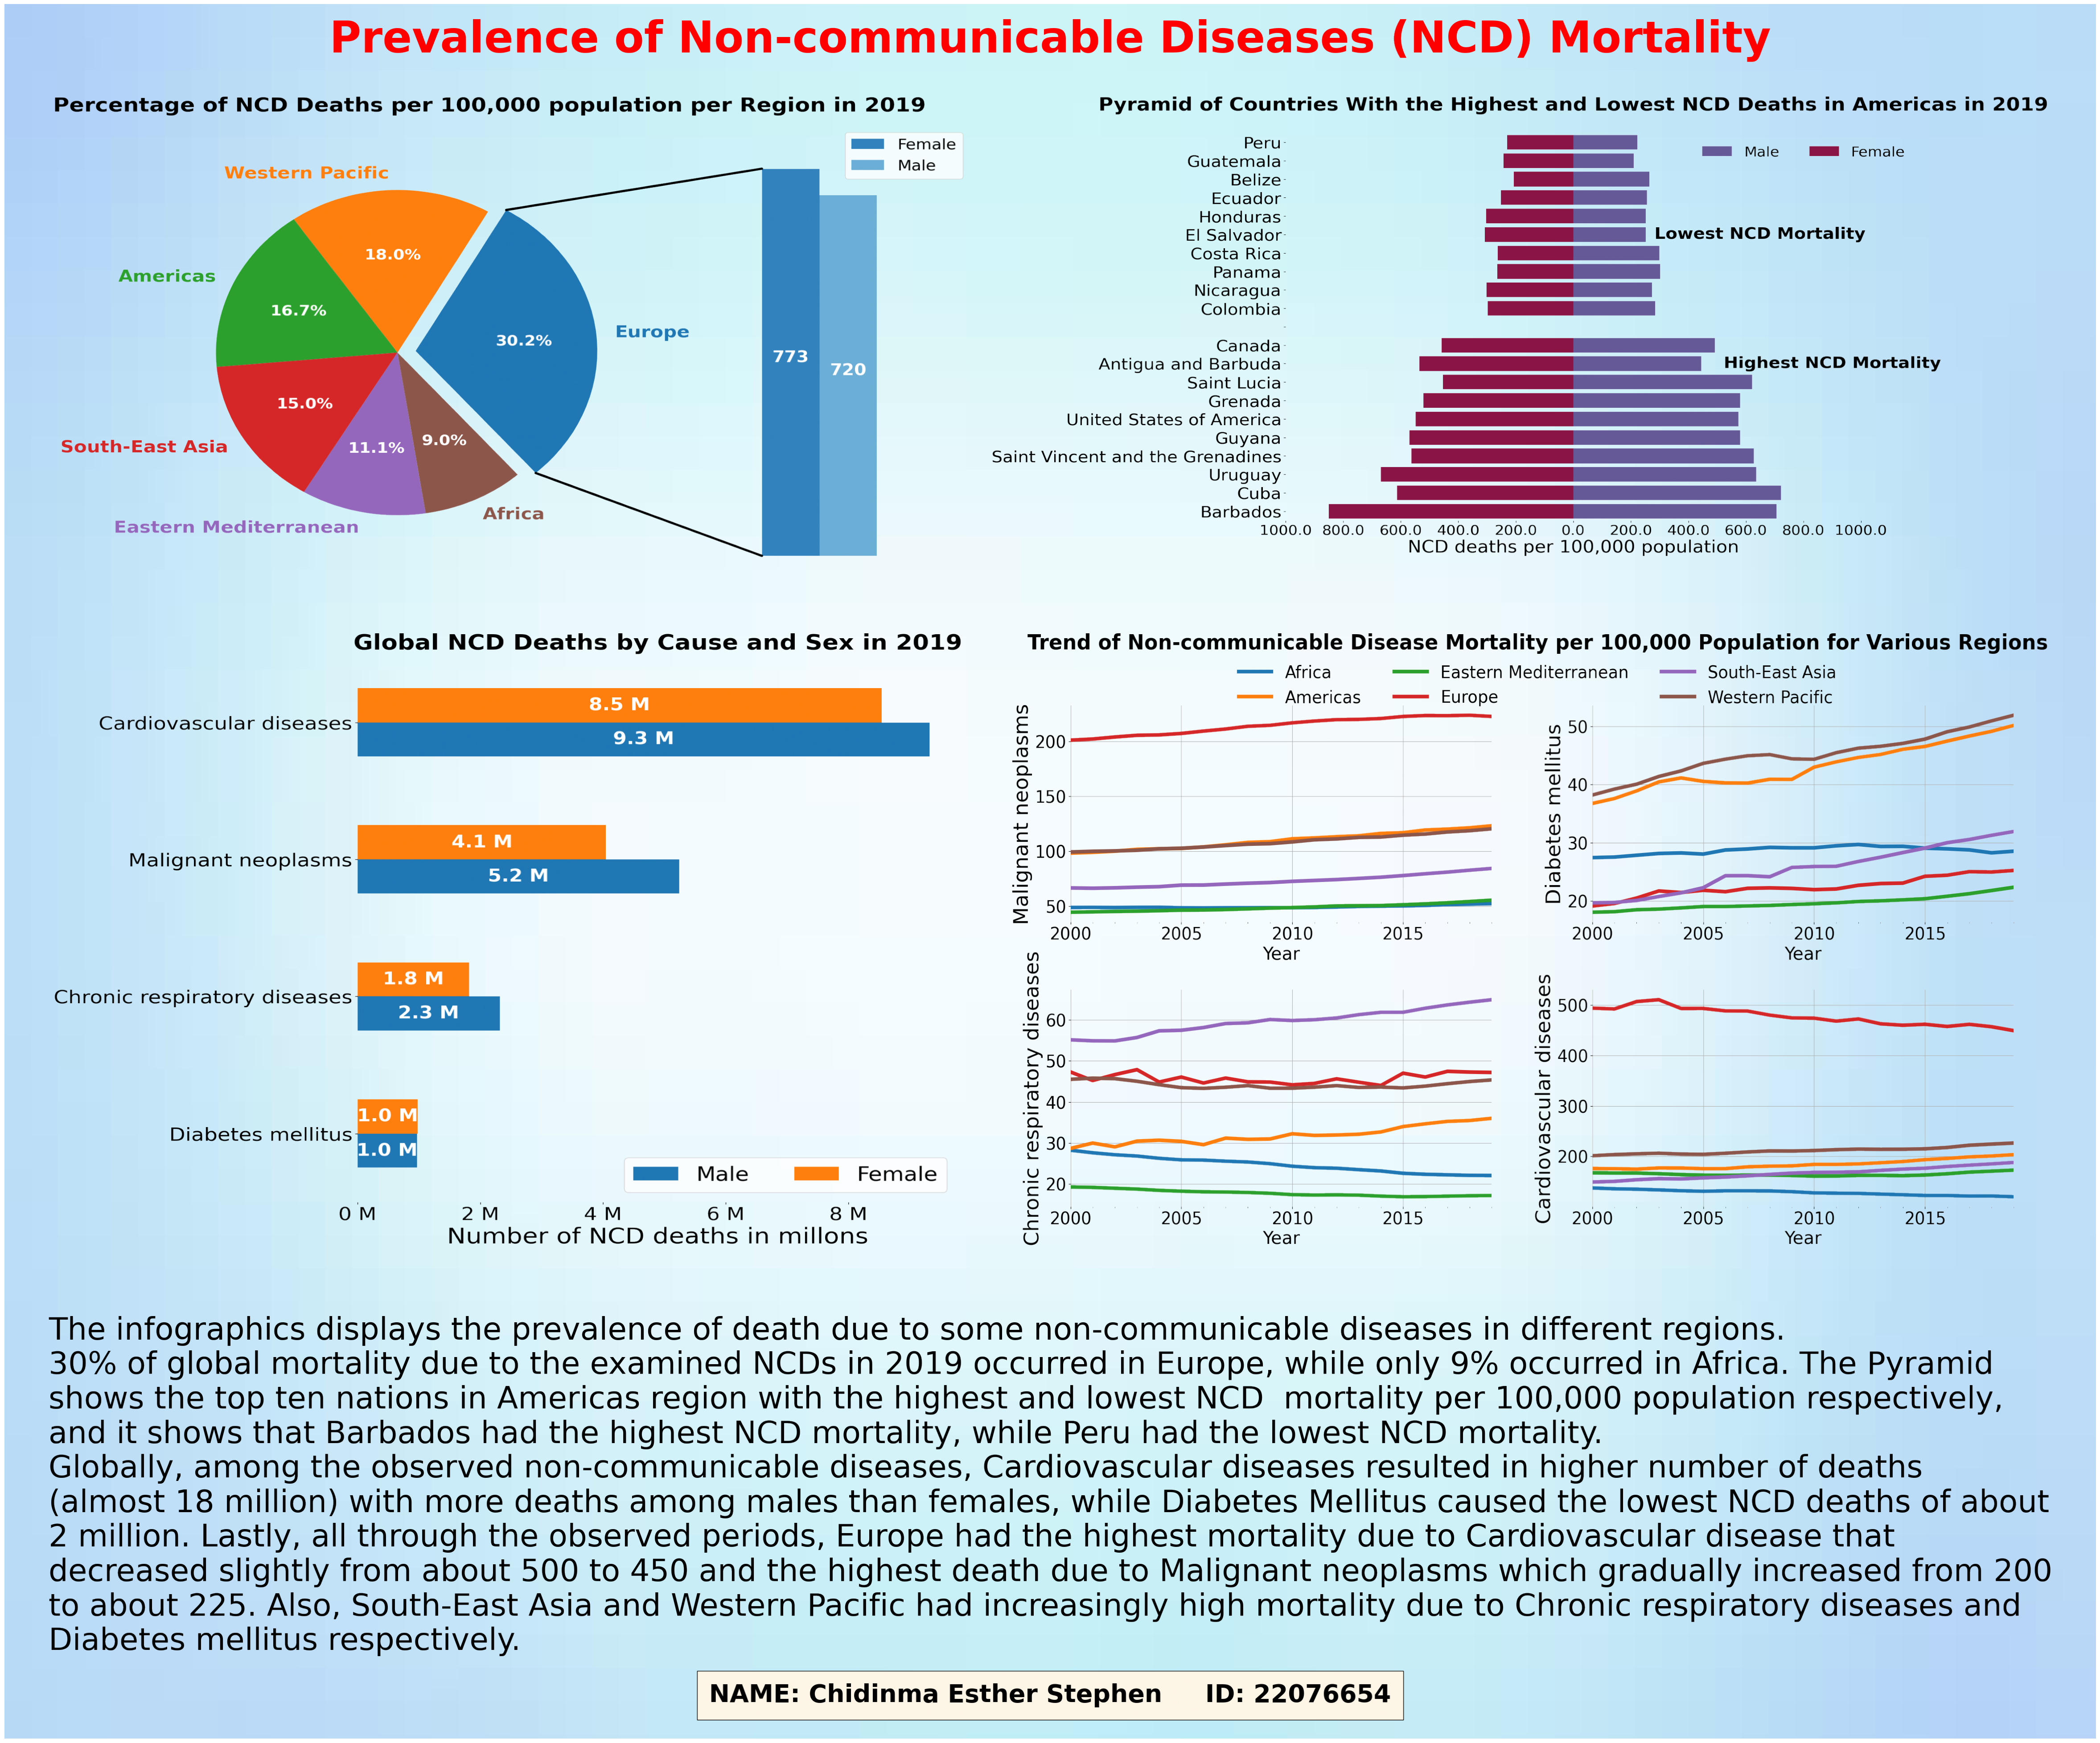

In [2]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

import seaborn as sns


def process_data(regions, ncd_mortality, population):
    """
    Cleans the loaded data, process and merge them to a single dataframe

    Parameters
    ----------
    regions : DataFrame
        The dataframe containing countries and the region they fall under.
    ncd_mortality : DataFrame
        The dataframe containg non-communicable disesases deaths by their
        cause and sex from year 2000 to 2019 (20 years).
    population : DataFrame
        The dataframe containing the total number of people in each countries
        from year 2000 to 2019.

    Returns
    -------
    merged_df : DataFrame
        The merged dataframe containing ncd deaths by cause and sex for each
        countries, the regions and population for the respective countries.

    """
    # Clean the non-communicable diseases death data
    ncd_mortality.rename(
        columns={"Countries, territories and areas": "Country",
                 "Both sexes": "Total"}, inplace=True)
    # The number of death is given along with the lower and upper limit, we
    # extract just the number of deaths e.g 15565 [7609-28280] becomes 15565
    gender_columns = ["Total", "Male", "Female"]
    ncd_mortality[gender_columns] = ncd_mortality[gender_columns].apply(
        lambda x: pd.to_numeric(x.str.split("[").str[0]))

    # Clean the population data
    population.drop(
        columns=["Series Code", "Country Name"], inplace=True)
    # Change column names like "2000 [YR2000]" to "2000"
    columns = ["Sex" if name == "Series Name"
               else name.split(" [")[0] for name in list(population.columns)]
    population.columns = columns
    population.loc[population["Sex"] == "Population, female", "Sex"] = "Male"
    population.loc[population["Sex"] == "Population, male", "Sex"] = "Female"
    population.loc[population["Sex"] == "Population, total", "Sex"] = "Total"
    # Reshape the population data
    population = population.melt(id_vars=["Country Code", "Sex"],
                                 var_name='Year', value_name='Population')
    population["Year"] = pd.to_datetime(population["Year"], format="%Y")

    # Merge the ncd mortality and regions data, so that the merged data
    # includes the region for each country
    ncd_regions = pd.merge(ncd_mortality, regions, on="Country")
    # Join Male, Female, and Total columns to a single column
    ncd_regions = ncd_regions.melt(
        id_vars=["Country", "Country Code", "Year", "Causes", "Region"],
        var_name='Sex', value_vars=['Total', 'Male', 'Female'],
        value_name='Number of Deaths')
    ncd_regions["Year"] = pd.to_datetime(ncd_regions["Year"], format="%Y")

    # Merge the population data to the ncd mortality and regions data
    merged_df = pd.merge(ncd_regions, population, on=[
        "Country Code", "Year", "Sex"], sort=True)
    # Create new Deaths per 100,000 population column
    merged_df["Deaths per 100,000"] = (
        merged_df["Number of Deaths"] / merged_df["Population"]) * 100000

    return merged_df


def plot_pie_bar(df_2019):
    """
    Plots pie chart showing the percentage of NCD mortality per 100,000
    population per region in 2019

    Parameters
    ----------
    df_2019 : DataFrame
        The dataframe containing NCD deaths in 2019.

    Returns
    -------
    None.

    """

    # Get the mortality per 100,000 population for all regions and all NCD
    df_region = pd.pivot_table(df_2019, values="Deaths per 100,000",
                               columns=["Region", "Causes"],
                               index="Sex").transpose()

    # Sum the mortality for all examined NCDs per 100,000 population
    df_to_plot = df_region.groupby("Region", level="Causes").sum()
    df_to_plot.sort_values(by="Total", ascending=False, inplace=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 13),
                                   width_ratios=[3, 1])
    fig.subplots_adjust(wspace=0)
    fig.suptitle("Percentage of NCD Deaths per 100,000 population per " +
                 "Region in 2019",
                 fontweight="bold", fontsize=35)

    df_total = df_to_plot["Total"]
    explode = [0.1 if x == 1 else 0 for x in df_total >= df_total.max()]
    # Plot the pie chart and rotate it to place the first wedge in
    # the desired position
    patches, texts, pcts = ax1.pie(df_to_plot.sum(axis=1),
                                   labels=df_to_plot.index, autopct='%1.1f%%',
                                   startangle=-180 * 0.27, explode=explode)

    # Set the text color outside each patch to the color of the patch
    for i, patch in enumerate(patches):
        texts[i].set_color(patch.get_facecolor())
        texts[i].set_fontweight("bold")
        texts[i].set_fontsize(30)

    # Change the color of the percentage text inside the pie to white
    plt.setp(pcts, color='white', fontweight="bold", fontsize=26)

    # Plot the bar chart showing the male and female NCD mortality per 100,000
    # for the region with the highest NCD mortality
    width = 0.6
    df_to_plot.loc[["Europe"], ["Female", "Male"]].plot.bar(
        ax=ax2, width=width, color=plt.colormaps["tab20c"]([0, 1]))

    # Show the male and female NCD mortality per 100,000 population in the bars
    for p in ax2.patches:
        ax2.annotate(str(p.get_height().round().astype(int)),
                     (p.get_x() + (p.get_width() / 2), p.get_height()/2),
                     ha="center", color='w', weight='bold', fontsize=28)

    ax2.legend(loc=("upper center"), fontsize=26, bbox_to_anchor=[0.9, 1.06])
    ax2.axis('off')

    # Draw lines between the pie and bar plots with ConnectionPatch
    theta1, theta2 = patches[0].theta1, patches[0].theta2
    center, r = patches[0].center, patches[0].r
    bar_height = np.max(df_to_plot.loc[["Europe"]].values)

    # Draw the top connecting line
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = r * np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    con.set_linewidth(4)
    ax2.add_artist(con)

    # Draw the bottom connecting line
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = r * np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    ax2.add_artist(con)
    con.set_linewidth(4)

    plt.savefig("plots/pie_plot.png", bbox_inches="tight", transparent=True)
    plt.close()

    return


def plot_pyramid(df_2019):
    """
    Plots population pyramid of deaths due to non-communicable diseases per 
    100,000 population in some countries in the Americas region for both
    Male and Female in 2019

    Parameters
    ----------
    df_2019: DataFrame
        The dataframe containing NCD deaths in 2019.

    Returns
    -------
    None.

    """
    fig, ax = plt.subplots(figsize=(23, 12), layout='constrained')

    # Sum the NCD mortality for all examined NCDs per 100,000 population
    # in each country for the year 2019 and select data for Americas region.
    df_americas_2019 = pd.pivot_table(df_2019, index="Sex",
                                      values="Deaths per 100,000",
                                      columns=["Region", "Country"],
                                      aggfunc=np.sum).xs("Americas", axis=1,
                                                         level=0).T

    # Sort the dataframe by the average mortality rate of both gender
    df = df_americas_2019.sort_values(
        by="Total")[["Male", "Female"]].reset_index()

    # Set the mortality rate for females to negative to enable plotting
    # the population pyramid correctly
    df["Female"] = df["Female"]*-1

    # Select the first ten countries
    df1 = df[:10]
    # Create an empty dataframe for creating space between the bars
    df_empty = pd.DataFrame({"Country": [""], "Female": [0], "Male": [0]})
    # Select the last ten countries
    df2 = df[-10:]

    # Merge the dataframes
    df = pd.concat([df1, df_empty, df2])

    # Reshape the dataframe for easy plotting
    df = df.melt(id_vars="Country", value_name="Deaths", var_name="Sex")

    sns.barplot(x='Deaths', y='Country', data=df, hue="Sex", dodge=False,
                palette=[plt.cm.Spectral(1.0), plt.cm.Spectral(0.0)])

    ax.set_ylabel(None)
    ax.set_xlabel("NCD deaths per 100,000 population", fontsize=32)
    ax.tick_params(axis='y', labelsize=30)
    ticks = ax.get_xticks()
    ax.set_xticks(ticks=ticks, labels=[abs(i) for i in ticks], size=26)
    ax.set_title("Pyramid of Countries With the Highest and Lowest NCD " +
                 "Deaths in Americas in 2019",
                 fontweight="bold", fontsize=35, y=1.05)
    ax.set_frame_on(False)
    ax.legend(loc="upper right", ncols=2, fontsize=26, frameon=False,
              bbox_to_anchor=[1.10, 1.0])

    # Add text to differenciate the two data groups
    ax.text(s="Lowest NCD Mortality", x=650, y=5,
            ha="center", va="center", size=30, weight="bold")
    ax.text(s="Highest NCD Mortality", x=900, y=12,
            ha="center", va="center", size=30, weight="bold")

    plt.savefig("plots/pyramid.png", bbox_inches="tight", transparent=True)
    plt.close()

    return


def plot_bar_graph(df_2019):
    """
    Plots a bar graph of the global mortality due to the examined NCDs

    Parameters
    ----------
    df_2019 : The dataframe containing NCD deaths in 2019

    Returns
    -------
    None.

    """
    df = pd.pivot_table(df_2019, values="Number of Deaths", index="Causes",
                        columns="Sex", aggfunc=np.sum).sort_values(
        by="Total")[["Male", "Female"]]
    df_millions = df / 1_000_000

    fig, ax = plt.subplots(figsize=(18, 14),  layout='constrained')

    df_millions.plot.barh(ax=ax, fontsize=30)
    ax.set_title("Global NCD Deaths by Cause and Sex in 2019",
                 fontweight="bold", fontsize=34)

    # Show the corresponding number of deaths in each bar
    for p in ax.patches:
        ax.text(x=p.get_width() / 2, y=p.get_y() + p.get_height() / 2,
                s=f"{p.get_width().round(1)} M", ha="center",
                va="center", color="w", weight='bold', size=28)

    ax.set_frame_on(False)
    ax.set_ylabel(None)
    ax.set_xlabel("Number of NCD deaths in millons", fontsize=36)
    ax.xaxis.set_major_formatter('{x:0.0f} M')
    ax.legend(fontsize=32, ncols=2)

    plt.savefig("plots/bar_plot.png", bbox_inches="tight", transparent=True)
    plt.close()

    return


def plot_line_graph(df):
    """
    Plots line graph showing the trend of deaths due to the examined 
    non-communicable disease in different regions

    Parameters
    ----------
    df : DataFrame
        The dataframe containing NCD deaths across countries.

    Returns
    -------
    None.

    """
    # Group the data by region and cause of death for each year
    df_regions = pd.pivot_table(df, values="Deaths per 100,000",
                                index=["Year", "Sex"], columns=[
                                    "Region", "Causes"], aggfunc=np.mean,
                                sort=True)
    # Select the deaths per 100,000 population for both male and female
    df_regions = df_regions.xs("Total", level="Sex")

    fig, axes = plt.subplots(2, 2, figsize=(23, 12))
    fig.tight_layout(w_pad=14.0, h_pad=9.0)

    title = ("Trend of Non-communicable Disease Mortality per 100,000 " +
             "Population for Various Regions")
    fig.suptitle(title, fontsize=34, fontweight="bold", y=1.12)

    row = 0
    col = 0
    # Sort the columns to place the subplots in the desired order
    sorted_columns = df_regions.columns.levels[1].sort_values(ascending=False)
    for disease in sorted_columns:
        df_to_plot = df_regions.xs(disease, level="Causes", axis=1)
        ax = axes[row, col]

        df_to_plot.plot(ax=ax, legend=False, grid=True, xlim=("2000", "2019"),
                        linewidth=6)

        ax.set_ylabel(disease, fontsize=34)
        ax.set_xlabel("Year", fontsize=30)
        ax.tick_params(axis='x', labelsize=28)
        ax.tick_params(axis='y', labelsize=28)
        ax.set_frame_on(False)

        # Set the axes to make the next plot on
        if col < 1:
            col += 1
        else:
            row += 1
            col = 0

    # Display one legend for all the subplots
    handles, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncols=3, frameon=False,
               bbox_to_anchor=[0.5, 1.09], fontsize=28)

    plt.savefig("plots/line_plot.png", bbox_inches="tight", transparent=True)
    plt.close()

    return


def create_infographics(df):
    """
    Combines the plots to generate one plot with a title and short report

    Parameters
    ----------
    df : DataFrame
        The dataframe containing NCD deaths across countries.

    Returns
    -------
    None.

    """
    df_2019 = df[df['Year'] == "2019"]

    # Create the canvas to place the plots
    fig, ax = plt.subplots(figsize=(47, 39), layout="constrained")
    canvas = np.zeros([100, 100, 3], dtype=np.uint8)

    # Create the folder to save the plots to
    if not os.path.isdir("plots"):
        os.makedirs("plots")

    # Make the individual plots and save them as pngs in the plots folder
    plot_pie_bar(df_2019)
    plot_pyramid(df_2019)
    plot_bar_graph(df_2019)
    plot_line_graph(data)

    pie_img = plt.imread('plots/pie_plot.png')
    pyramid_img = plt.imread('plots/pyramid.png')
    bar_img = plt.imread('plots/bar_plot.png')
    line_plot_img = plt.imread('plots/line_plot.png')

    # Place the images on the canvas
    ax.imshow(pie_img, aspect='auto', alpha=1, extent=(2, 46, 68, 95))
    ax.imshow(pyramid_img, aspect='auto', alpha=1, extent=(47, 98, 68, 95))
    ax.imshow(bar_img, aspect='auto', alpha=1, extent=(2, 46, 28, 64))
    ax.imshow(line_plot_img, aspect='auto', alpha=1, extent=(48, 98, 28, 64))
    ax.imshow(canvas, aspect='auto', alpha=0, extent=(0, 100, 0, 100))

    # Add the title and report to the canvas
    title = "Prevalence of Non-communicable Diseases (NCD) Mortality"
    report = ("The infographics displays the prevalence of death due to " +
              "some non-communicable diseases in different regions.\n30% " +
              "of global mortality due to the examined NCDs in 2019 " +
              "occurred in Europe, while only 9% occurred in Africa. The " +
              "Pyramid\nshows the top ten nations in Americas region with " +
              "the highest and lowest NCD  mortality per 100,000 population " +
              "respectively,\nand it shows that Barbados had the highest " +
              "NCD mortality, while Peru had the lowest NCD mortality.\n" +
              "Globally, among the observed non-communicable diseases, " +
              "Cardiovascular diseases resulted in higher number of deaths\n" +
              "(almost 18 million) with more deaths among males than " +
              "females, while Diabetes Mellitus caused the lowest NCD " +
              "deaths of about\n2 million. Lastly, all through the " +
              "observed periods, Europe had the highest mortality due to " +
              "Cardiovascular disease that\ndecreased slightly from " +
              "about 500 to 450 and the highest death due to Malignant " +
              "neoplasms which gradually increased from 200\nto about 225. " +
              "Also, South-East Asia and Western Pacific had increasingly " +
              "high mortality due to Chronic respiratory diseases and " +
              "\nDiabetes mellitus respectively."
              )
    name_and_id = "NAME: Chidinma Esther Stephen     ID: 22076654"
    ax.text(50, 98, title,
            va="center", ha='center',
            color="red", fontsize=70, weight='bold')
    ax.text(2, 5, report, ha="left", va="baseline", color='black',
            fontsize=50, clip_on=True)
    ax.text(50, 2, name_and_id, va="baseline", ha="center", fontsize=40,
            fontweight="bold", bbox={"fc": "oldlace",
                                 "boxstyle": "square,pad=0.5"})

    plt.axis('off')

    plt.savefig("plots/combined_plots.png", transparent=True)
    plt.close()

    return


# Read the data with pandas
regions = pd.read_csv("regions.csv")
ncd_mortality = pd.read_csv("NCD-deaths.csv", skiprows=1)
population = pd.read_csv("population.csv")

data = process_data(regions, ncd_mortality, population)

# Produce the infographics
create_infographics(data)

# Add background image to the infographis
fig = plt.figure(figsize=(47, 39), layout="constrained")

infographics = plt.imread('plots/combined_plots.png')
background_img = plt.imread('background_image.jpg')

plt.imshow(background_img, aspect='auto', extent=(0, 100, 0, 100))
plt.axis('off')

fig.add_subplot(111)
plt.imshow(infographics)
plt.axis('off')

# Delete the plots folder containing the individual plots
shutil.rmtree("plots")

plt.show()